In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report, roc_auc_score
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance

RNG = 42
DATA_PATH = Path("data.csv")

pd.set_option("display.max_columns", 200)


In [55]:

# === 1) Load data ===
df = pd.read_csv(DATA_PATH)
# Try common target names; fallback to Injury_Next_Season
target = df["Injury_Next_Season"].name

y = df[target].astype(int)
X = df.drop(columns=[target])

# Cast object -> category
for c in X.columns:
    if X[c].dtype == "object":
        X[c] = X[c].astype("category")

X = X.drop(columns=["BMI"])

cat_cols = [c for c in X.columns if str(X[c].dtype) == "category"]
num_cols = [c for c in X.columns if c not in cat_cols]

print("Target:", target)
print("n rows:", len(df))
print("Numerical:", len(num_cols), "| Categorical:", len(cat_cols))


Target: Injury_Next_Season
n rows: 800
Numerical: 16 | Categorical: 1


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RNG)

In [57]:

pre = ColumnTransformer([
    ("num", Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(drop="first", handle_unknown="ignore"))
    ]), cat_cols),
])

logreg = LogisticRegression(C=0.2, max_iter=2000, random_state=RNG)

pipe = Pipeline([("pre", pre), ("clf", logreg)])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RNG)
cv_roc = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc", n_jobs=1).mean()
cv_pr = cross_val_score(pipe, X, y, cv=cv, scoring="average_precision", n_jobs=1).mean()
print(f"CV AUROC ~ {cv_roc:.3f} | CV PR AUC ~ {cv_pr:.3f}")

pipe.fit(X_train, y_train)
proba_test = pipe.predict_proba(X_test)[:, 1]
print(proba_test)


CV AUROC ~ 0.991 | CV PR AUC ~ 0.992
[9.82855677e-01 2.22624218e-03 2.29539728e-02 7.97607569e-01
 4.95919011e-01 5.27945539e-03 9.82344859e-01 6.85514053e-03
 7.72954078e-04 9.97660942e-01 2.70624157e-03 1.51174319e-02
 9.99515575e-01 4.05974140e-02 5.15732185e-03 1.22782570e-01
 4.42826043e-01 9.69519590e-01 2.45315615e-03 9.93063919e-01
 8.34291129e-01 9.85280511e-01 8.13029348e-02 6.02503982e-01
 9.90744430e-04 6.04653788e-01 1.86781305e-02 1.03552372e-02
 9.85650419e-01 1.82322674e-02 2.77249371e-03 9.94367247e-01
 9.99237331e-01 1.09134683e-03 9.95483295e-01 2.07369746e-02
 1.21660072e-01 9.93481555e-01 2.79452655e-01 9.54616517e-01
 9.99512132e-01 9.98834828e-01 4.25219607e-03 2.70313111e-02
 9.94021964e-01 6.03563998e-01 8.87045741e-01 6.52206642e-01
 4.47710475e-02 9.96071136e-01 6.39750684e-03 3.49494631e-02
 9.85892397e-01 1.55481384e-03 5.90351296e-01 7.90689339e-01
 4.02252860e-03 7.75797970e-03 8.25395193e-01 9.56850727e-01
 8.94233424e-02 1.82586847e-03 3.60780990e-02 9.

In [58]:
prec, rec, thr = precision_recall_curve(y_test, proba_test)
prec_m, rec_m, thr_m = prec[:-1], rec[:-1], thr
f1 = 2 * prec_m * rec_m / (prec_m + rec_m + 1e-9)
t_best_f1 = float(thr_m[np.nanargmax(f1)]) if thr_m.size else 0.5

y_hat = (proba_test >= t_best_f1).astype(int)
print(f"Best-F1 threshold = {t_best_f1:.3f}")
print(classification_report(y_test, y_hat))
print("Confusion matrix:\n", confusion_matrix(y_test, y_hat))
print("Holdout AUROC:", round(roc_auc_score(y_test, proba_test), 3))
print("Holdout PR AUC:", round(average_precision_score(y_test, proba_test), 3))


Best-F1 threshold = 0.484
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        80
           1       0.98      0.99      0.98        80

    accuracy                           0.98       160
   macro avg       0.98      0.98      0.98       160
weighted avg       0.98      0.98      0.98       160

Confusion matrix:
 [[78  2]
 [ 1 79]]
Holdout AUROC: 0.998
Holdout PR AUC: 0.998


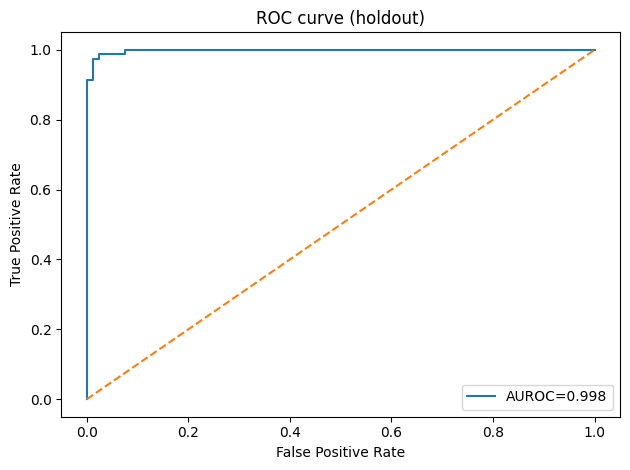

In [59]:
fpr, tpr, _ = roc_curve(y_test, proba_test)
plt.figure()
plt.plot(fpr, tpr, label=f"AUROC={auc(fpr,tpr):.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.title("ROC curve (holdout)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()


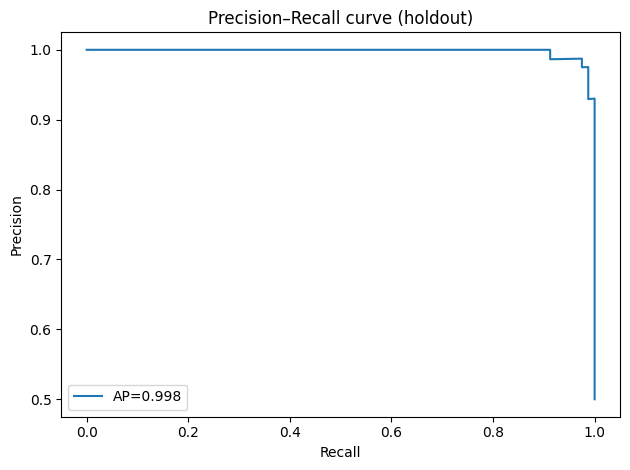

In [60]:
P, R, _ = precision_recall_curve(y_test, proba_test)
ap = average_precision_score(y_test, proba_test)
plt.figure()
plt.plot(R, P, label=f"AP={ap:.3f}")
plt.title("Precision–Recall curve (holdout)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.show()


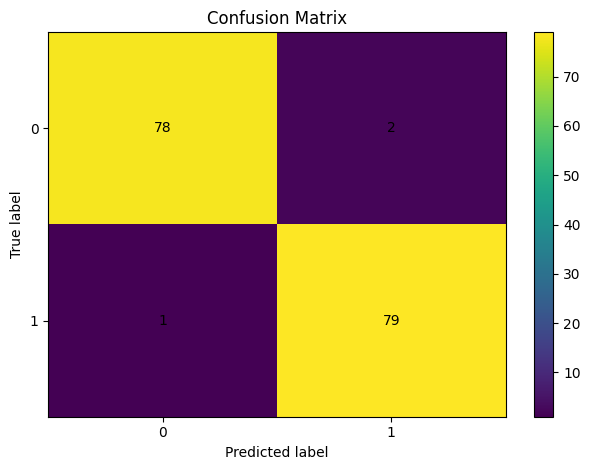

In [61]:
cm = confusion_matrix(y_test, y_hat)
plt.figure()
plt.imshow(cm, interpolation='nearest', aspect='auto')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["0","1"])
plt.yticks(tick_marks, ["0","1"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


In [62]:
cal = CalibratedClassifierCV(estimator=pipe, method="isotonic", cv=3)
cal.fit(X_train, y_train)
proba_cal = cal.predict_proba(X_test)[:, 1]

from sklearn.metrics import brier_score_loss
print("Brier (uncal):", round(brier_score_loss(y_test, proba_test), 4))
print("Brier (cal)  :", round(brier_score_loss(y_test, proba_cal), 4))


Brier (uncal): 0.0273
Brier (cal)  : 0.0248


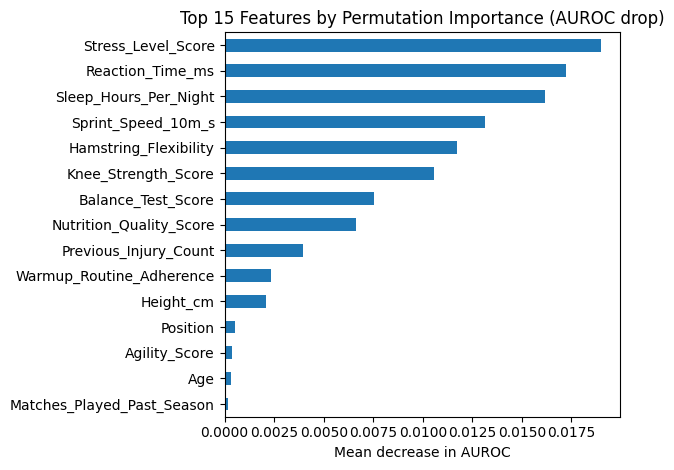

Near-zero features (PI <= 0.001): ['Position', 'Agility_Score', 'Age', 'Matches_Played_Past_Season', 'Training_Hours_Per_Week', 'Weight_kg']


In [63]:
perm = permutation_importance(pipe, X_test, y_test, n_repeats=5, random_state=RNG, scoring="roc_auc", n_jobs=1)
fi = pd.Series(perm.importances_mean, index=X_test.columns).sort_values(ascending=False)

plt.figure()
fi.head(15).sort_values().plot(kind="barh")
plt.title("Top 15 Features by Permutation Importance (AUROC drop)")
plt.xlabel("Mean decrease in AUROC")
plt.tight_layout()
plt.show()

low_value_feats = fi[fi <= 0.001].index.tolist()
print("Near-zero features (PI <= 0.001):", low_value_feats)


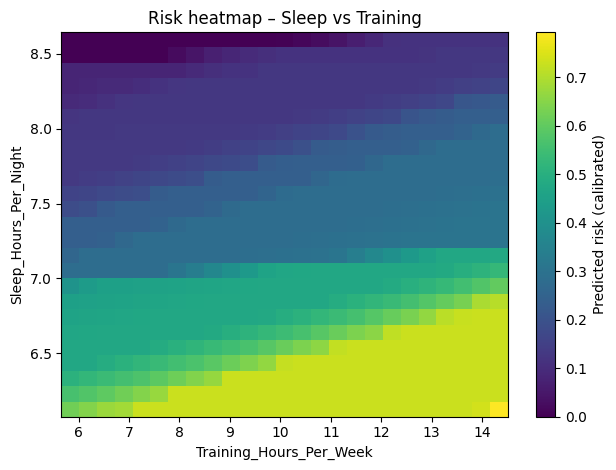

In [64]:
sleep_col = "Sleep_Hours_Per_Night" if "Sleep_Hours_Per_Night" in X.columns else None
train_col = "Training_Hours_Per_Week" if "Training_Hours_Per_Week" in X.columns else None

if sleep_col and train_col:
    s_min, s_max = np.percentile(X_train[sleep_col].dropna(), [5,95])
    t_min, t_max = np.percentile(X_train[train_col].dropna(), [5,95])
    s_vals = np.linspace(s_min, s_max, 25)
    t_vals = np.linspace(t_min, t_max, 25)

    grid = []
    num_defaults = X_train.select_dtypes(include=np.number).median()
    cat_df = X_train.select_dtypes(exclude=np.number)
    cat_defaults = cat_df.mode().iloc[0] if not cat_df.empty else pd.Series(dtype=object)

    for sv in s_vals:
        for tv in t_vals:
            row = {}
            for c in X_train.columns:
                if c == sleep_col: row[c] = sv
                elif c == train_col: row[c] = tv
                elif c in num_defaults.index: row[c] = num_defaults[c]
                elif c in cat_defaults.index: row[c] = cat_defaults[c]
                else: row[c] = None
            grid.append(row)
    G = pd.DataFrame(grid, columns=X_train.columns)

    risk = cal.predict_proba(G)[:,1].reshape(len(s_vals), len(t_vals))

    plt.figure()
    plt.imshow(risk, extent=[t_vals.min(), t_vals.max(), s_vals.min(), s_vals.max()], origin="lower", aspect="auto")
    plt.colorbar(label="Predicted risk (calibrated)")
    plt.title("Risk heatmap – Sleep vs Training")
    plt.xlabel(train_col)
    plt.ylabel(sleep_col)
    plt.tight_layout()
    plt.show()
else:
    print("Sleep/Training columns not found; skipping heatmap.")


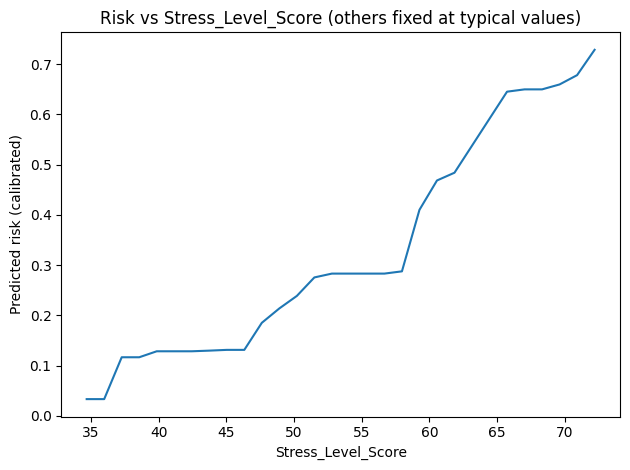

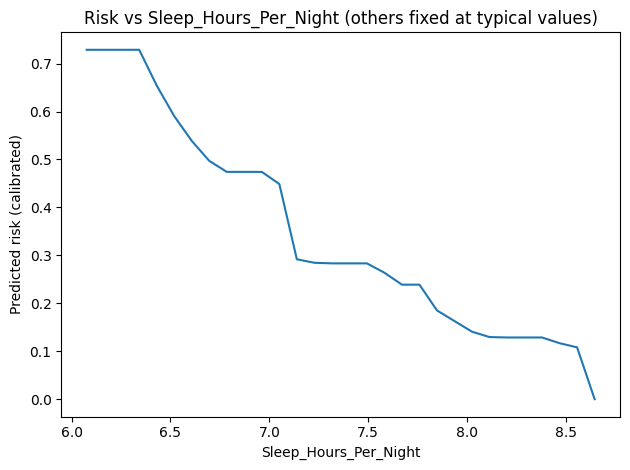

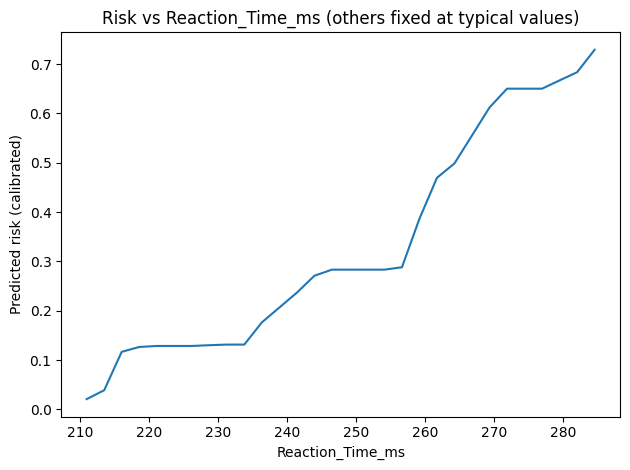

In [65]:
candidates = [c for c in ["Stress_Level_Score","Sleep_Hours_Per_Night", "Reaction_Time_ms"] if c in X.columns]
if candidates:
    num_defaults = X_train.select_dtypes(include=np.number).median()
    cat_df = X_train.select_dtypes(exclude=np.number)
    cat_defaults = cat_df.mode().iloc[0] if not cat_df.empty else pd.Series(dtype=object)

    for feat in candidates[:3]:
        vals = np.linspace(*np.percentile(X_train[feat].dropna(), [5,95]), 30)
        rows = []
        for v in vals:
            row = {}
            for c in X_train.columns:
                if c == feat: row[c] = v
                elif c in num_defaults.index: row[c] = num_defaults[c]
                elif c in cat_defaults.index: row[c] = cat_defaults[c]
                else: row[c] = None
            rows.append(row)
        G = pd.DataFrame(rows, columns=X_train.columns)
        risk = cal.predict_proba(G)[:,1]

        plt.figure()
        plt.plot(vals, risk)
        plt.title(f"Risk vs {feat} (others fixed at typical values)")
        plt.xlabel(feat)
        plt.ylabel("Predicted risk (calibrated)")
        plt.tight_layout()
        plt.show()
else:
    print("No candidate numeric features found for 1D curves.")


In [71]:
drop_feats = fi[fi <= 0.001].index.tolist()
print("Dropping these features:", drop_feats)

X2 = X.drop(columns=drop_feats) if drop_feats else X.copy()
cat_cols2 = [c for c in X2.columns if str(X2[c].dtype) == "category"]
num_cols2 = [c for c in X2.columns if c not in cat_cols2]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.2, stratify=y, random_state=RNG)

pre2 = ColumnTransformer([
    ("num", Pipeline([("impute", SimpleImputer(strategy="median")), ("scale", StandardScaler())]), num_cols2),
    ("cat", Pipeline([("impute", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(drop="first", handle_unknown="ignore"))]), cat_cols2),
])
pipe2 = Pipeline([("pre", pre2), ("clf", LogisticRegression(C=0.2, max_iter=2000, random_state=RNG))])
pipe2.fit(X2_train, y2_train)
proba2 = pipe2.predict_proba(X2_test)[:,1]

print("=== Before drop ===")
print("AUROC:", round(roc_auc_score(y_test, proba_test),3), "| AP:", round(average_precision_score(y_test, proba_test),3))
print("\n=== After drop ===")
print("AUROC:", round(roc_auc_score(y2_test, proba2),3), " | AP:", round(average_precision_score(y2_test, proba2),3))

import joblib
from joblib import dump, load
# Make sure an output folder exists
Path("models").mkdir(exist_ok=True)


joblib.dump(pipe2, "models/injury_model.joblib")


Dropping these features: ['Position', 'Agility_Score', 'Age', 'Matches_Played_Past_Season', 'Training_Hours_Per_Week', 'Weight_kg']
=== Before drop ===
AUROC: 0.998 | AP: 0.998

=== After drop ===
AUROC: 0.999  | AP: 0.999


['models/injury_model.joblib']

In [67]:
# ...existing code...

# === Compute optimal threshold for pipe2 on the X2 holdout ===
from sklearn.metrics import precision_recall_curve
prec2, rec2, thr2 = precision_recall_curve(y2_test, proba2)
f1_2 = 2 * prec2[:-1] * rec2[:-1] / (prec2[:-1] + rec2[:-1] + 1e-9)
t_best_f1_2 = float(thr2[np.nanargmax(f1_2)]) if thr2.size else 0.5
print(f"Best-F1 threshold (pipe2) = {t_best_f1_2:.3f}")

# === Export final model (pipe2), its threshold, and its expected columns ===
import json, joblib
from pathlib import Path

out_dir = Path("models")
out_dir.mkdir(parents=True, exist_ok=True)

model_path = out_dir / "injury_model.joblib"
meta_path  = out_dir / "injury_meta.json"
feat_path  = out_dir / "features.json"

# Save the trained pipeline
joblib.dump(pipe2, model_path)

# Save threshold and small metadata for the app
meta = {
    "threshold": float(t_best_f1_2),
    "model_name": "pipe2",
    "has_predict_proba": hasattr(pipe2, "predict_proba")
}
with meta_path.open("w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

# Save the exact feature list the pipeline was trained on
with feat_path.open("w", encoding="utf-8") as f:
    json.dump(X2.columns.tolist(), f, indent=2)

print(f"Saved model -> {model_path}")
print(f"Saved meta  -> {meta_path}")
print(f"Saved features -> {feat_path}")

# IMPORTANT: Do NOT overwrite models/injury_model.joblib with (cal, threshold).
# If you still want a calibrated artifact, save it to a different path:
# joblib.dump((cal, t_best_f1_cal), out_dir / "injury_model_calibrated.joblib")
# ...existing code...

Best-F1 threshold (pipe2) = 0.356
Saved model -> models\injury_model.joblib
Saved meta  -> models\injury_meta.json
Saved features -> models\features.json


In [68]:
# create sample input for testing
sample = X2_test.iloc[0:10]

proba2 = pipe2.predict_proba(sample)
proba2

array([[0.00976479, 0.99023521],
       [0.99814747, 0.00185253],
       [0.95977376, 0.04022624],
       [0.21208918, 0.78791082],
       [0.30506681, 0.69493319],
       [0.9946839 , 0.0053161 ],
       [0.02081985, 0.97918015],
       [0.99744972, 0.00255028],
       [0.99748244, 0.00251756],
       [0.00348012, 0.99651988]])

In [69]:
X2_test.iloc[3]

Height_cm                   178.000000
Previous_Injury_Count         4.000000
Knee_Strength_Score          69.412925
Hamstring_Flexibility        79.681252
Reaction_Time_ms            229.614179
Balance_Test_Score           81.367092
Sprint_Speed_10m_s            6.134577
Sleep_Hours_Per_Night         7.660246
Stress_Level_Score           49.754053
Nutrition_Quality_Score      67.993225
Warmup_Routine_Adherence      0.000000
Name: 632, dtype: float64

In [70]:
X2.columns

Index(['Height_cm', 'Previous_Injury_Count', 'Knee_Strength_Score',
       'Hamstring_Flexibility', 'Reaction_Time_ms', 'Balance_Test_Score',
       'Sprint_Speed_10m_s', 'Sleep_Hours_Per_Night', 'Stress_Level_Score',
       'Nutrition_Quality_Score', 'Warmup_Routine_Adherence'],
      dtype='object')